In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [18]:
!pip install seaborn-0.13.2-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Processing ./seaborn-0.13.2-py3-none-any.whl


In [20]:
# Paths
data_dir = './dataset/cell_images'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [21]:
os.listdir(train_dir)

['parasitized', 'uninfected']

In [22]:
len(os.listdir(train_dir+'/uninfected/'))

12479

In [23]:
len(os.listdir(train_dir+'/parasitized/'))

12479

In [24]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [25]:
# Checking the image dimensions
dim1 = []
dim2 = []
for image_filename in os.listdir(test_dir+'/uninfected'):
    img = imread(test_dir+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

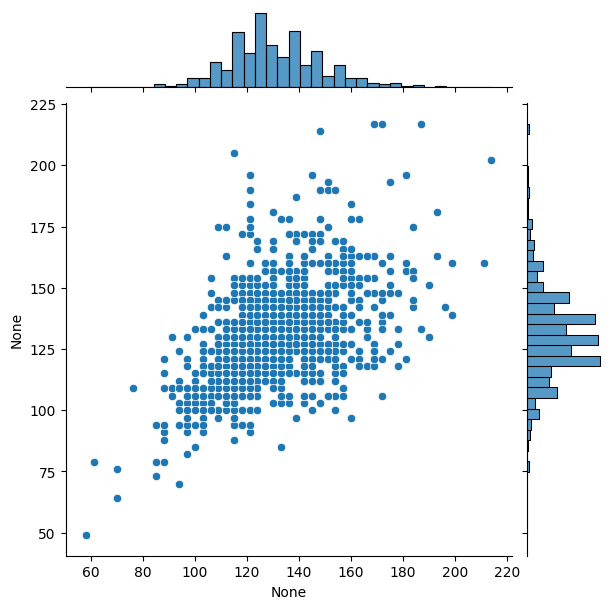

In [27]:
sns.jointplot(x=dim1,y=dim2)

In [28]:
# Parameters
image_size = (224, 224)  # ResNet expects 224x224
batch_size = 32
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])


In [30]:
# Load data
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [33]:
model = models.resnet18(weights=None)

# Modify the final layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

model = model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [36]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience=3):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            X, y = X.to(device), y.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device).float().unsqueeze(1)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model_resnet.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping triggered.')
                break

    print('Name: Yogeshvar')
    print('Register Number: 212222230180')


In [39]:
# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)



Epoch [1/5] - Train Loss: 0.1190 | Val Loss: 0.1108


Epoch [2/5] - Train Loss: 0.1129 | Val Loss: 0.1110


Epoch [3/5] - Train Loss: 0.1092 | Val Loss: 0.1032


Epoch [4/5] - Train Loss: 0.1065 | Val Loss: 0.1150


Epoch [5/5] - Train Loss: 0.1041 | Val Loss: 0.1026
Name: Yogeshvar
Register Number: 212222230180


In [40]:
# After training, load the best saved model
model.load_state_dict(torch.load('best_model_resnet.pth'))


<All keys matched successfully>

In [41]:
import seaborn as sns

In [42]:
def evaluate_model(model, test_loader, test_data):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device).float().unsqueeze(1)  # Ensure float for binary targets
            output = model(X)
            predicted = (output > 0.5).int()  # Binary prediction
            total += y.size(0)
            correct += (predicted == y.int()).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_names = test_data.classes  # ['parasitized', 'uninfected']

    print('Name:             ')
    print('Register Number:         ')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print('Name:             ')
    print('Register Number:         ')
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))



Test Accuracy: 0.9631
Name:             
Register Number:         


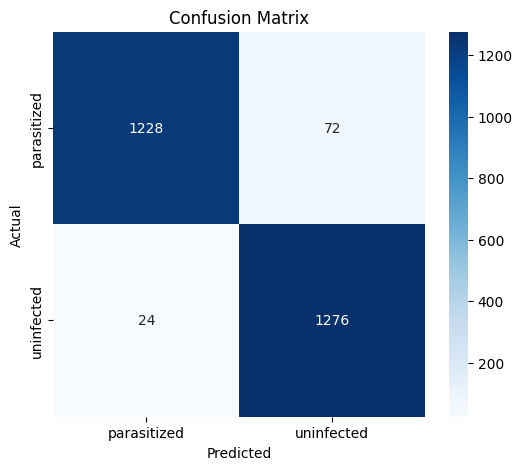

Name:             
Register Number:         
Classification Report:
              precision    recall  f1-score   support

 parasitized       0.98      0.94      0.96      1300
  uninfected       0.95      0.98      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



In [43]:
evaluate_model(model, test_loader, test_data)

In [44]:
import matplotlib.pyplot as plt

def predict_image(model, image_index, dataset, image_size=(130, 130)):
    model.eval()
    image, label = dataset[image_index]  # image is already transformed
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))  # Add batch dimension
        predicted = (output > 0.5).int()

    class_names = dataset.classes  # ['parasitized', 'uninfected']

    # Convert tensor image to numpy for plotting
    img_np = image.permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)

    # Display the image
    print('Name:            ')
    print('Register Number:         ')
    plt.imshow(img_np)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()



Name:             
Register Number:         


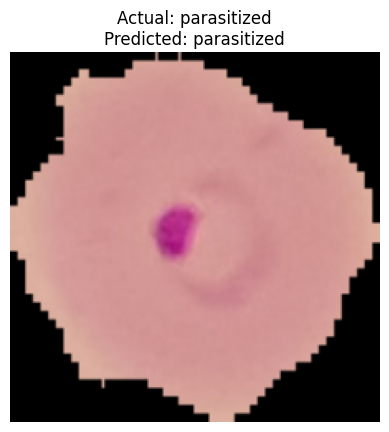

In [45]:
predict_image(model, image_index=5, dataset=test_data)

Name:             
Register Number:         


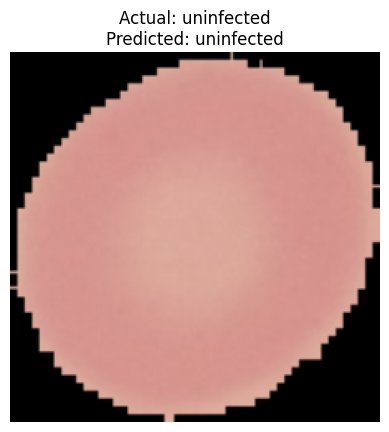

In [46]:
predict_image(model, image_index=1500, dataset=test_data)

Name:             
Register Number:         


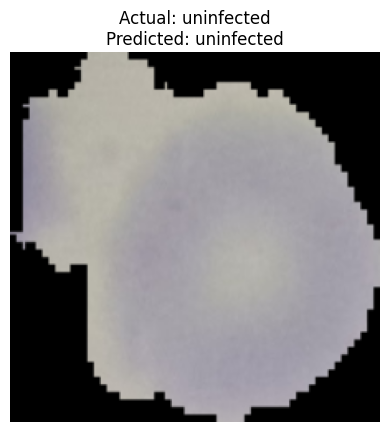

In [47]:
predict_image(model, image_index=1800, dataset=test_data)